In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lasio
import os
import glob
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from fastdtw import fastdtw
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from geopy.distance import geodesic
import networkx as nx

import time

In [2]:
# directory on personal computer
ruta = 'C:/Users/User/Desktop/Pan American Energy/reference scripts/initial'
os.chdir(ruta)

ruta_logs = ruta + "/Perfiles"
las_files = glob.glob(os.path.join(ruta_logs, '*.las'))

logs = {}

# Function to calculate geodesic distance between two points
def calculate_distance(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).meters

# Create a directed graph
G = nx.DiGraph()

# Set the separation distance between nodes
separation_distance = 2

# Reference latitude and longitude (you may want to set this based on your specific location)
reference_latitude = 0
reference_longitude = 0

# Create nodes in a grid layout and connect nodes within 200 meters
for i, las_file in enumerate(las_files):
    las = lasio.read(las_file)
    las_df = las.df().dropna()
    las_df = las_df.reset_index()

    # Calculate position in a grid layout
    rows = int(len(las_files)**0.5)
    cols = int(np.ceil(len(las_files) / rows))
    x = (i % rows) * separation_distance
    y = (i // rows) * separation_distance
    
    # Calculate latitude and longitude based on grid position
    latitude = reference_latitude + y * (1 / 111000)  # Approximately, latitude degrees per meter
    longitude = reference_longitude + x * (1 / (111000 * np.cos(np.radians(reference_latitude))))  # Approximately, longitude degrees per meter
    
    # Add node to the graph with the file name as the node name
    node_name = os.path.splitext(os.path.basename(las_file))[0]
    G.add_node(node_name, data=las_df, latitude=latitude, longitude=longitude, pos=(x, y))

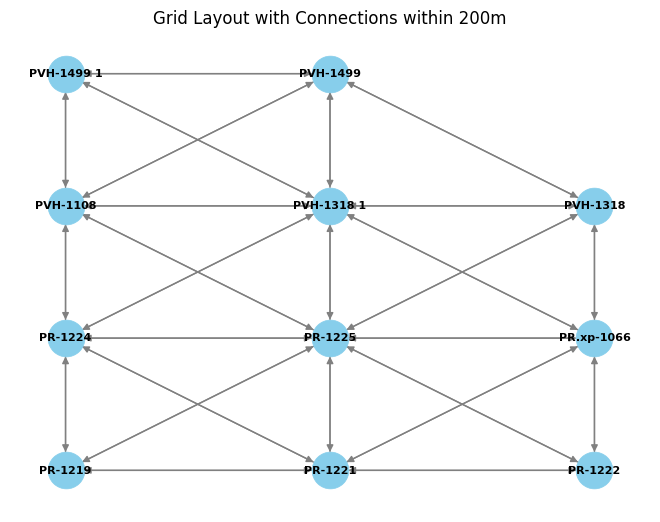

In [7]:
# Remove all connections (edges) from the graph
G.clear_edges()
# Connect nodes within 200 meters
for node_i, data_i in G.nodes(data=True):
    for node_j, data_j in G.nodes(data=True):
        if node_i != node_j:  # Avoid self-loops
            distance = calculate_distance(data_i['latitude'], data_i['longitude'],
                                          data_j['latitude'], data_j['longitude'])
            if distance < 3:
                G.add_edge(node_i, node_j)

# Draw the graph
plt.figure()
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue',
        font_size=8, font_color='black', font_weight='bold',
        arrowsize=10, edge_color='gray', linewidths=0.5)

plt.title('Grid Layout with Connections within 200m')
plt.show()

In [9]:
# Creating a dtw relationship between edges *hopefully*

#TODO what is this 
def assignWeights1(G, ref_node):
    for node, data in G.neighbors(ref_node):
        if node!=ref_node:
            log = data['data']
            return 1

def assignEdges(G, w=0.5):
    for node_i, data_i in G.nodes(data=True):
        for node_j, data_j in G.nodes(data=True):
            if node_i != node_j:  # Avoid self-loops
                # Extract well log data
                log_i = data_i['data']
                log_j = data_j['data']
                
                # Compute DTW distance
                distance, _ = fastdtw(log_i.values, log_j.values)
                
                # Add edge if DTW distance is below the threshold
                if distance < w:
                    G.add_edge(node_i, node_j, weight=distance)



Display graph again but this time with edges

In [11]:
G.clear_edges()

# Assign edges based on DTW distance
assignEdges(G, w=0.5)

# Draw the graph
plt.figure()
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue',
        font_size=8, font_color='black', font_weight='bold',
        arrowsize=10, edge_color='gray', linewidths=0.5)

#plt.title('Grid Layout with Connections based on DTW distance')
plt.show()

ValueError: second dimension of x and y must be the same